In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [13]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/AC Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

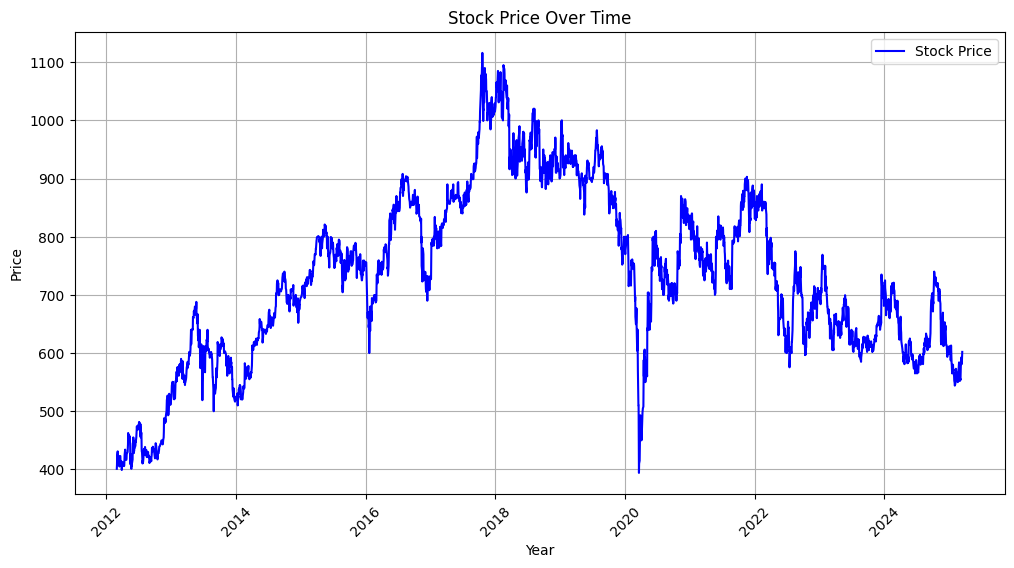

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

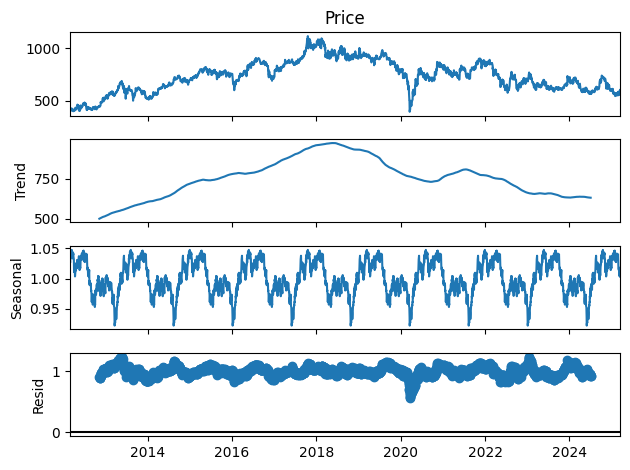

In [15]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [16]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [17]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [18]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [19]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [20]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("AC_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [22]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0103

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 263s 98ms/step - loss: 0.0103 - val_loss: 6.7373e-04
Epoch 2/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0018

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - loss: 0.0018 - val_loss: 4.8521e-04
Epoch 3/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0015

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 261s 99ms/step - loss: 0.0015 - val_loss: 4.3219e-04
Epoch 4/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0014

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 259s 98ms/step - loss: 0.0014 - val_loss: 3.1144e-04
Epoch 5/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0013

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 260s 99ms/step - loss: 0.0013 - val_loss: 2.6967e-04
Epoch 6/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - loss: 0.0012 - val_loss: 3.0941e-04
Epoch 7/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0011

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 273s 104ms/step - loss: 0.0011 - val_loss: 2.4967e-04
Epoch 8/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 309s 99ms/step - loss: 9.7629e-04 - val_loss: 6.2142e-04
Epoch 9/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - loss: 9.8645e-04 - val_loss: 2.6067e-04
Epoch 10/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - loss: 8.6560e-04 - val_loss: 2.6601e-04
Epoch 11/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 259s 99ms/step - loss: 9.2260e-04 - val_loss: 6.8160e-04
Epoch 12/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 9.1079e-04

2632/2632 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - loss: 9.1080e-04 - val_loss: 2.3789e-04
Epoch 13/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 267s 100ms/step - loss: 8.6927e-04 - val_loss: 8.2678e-04
Epoch 14/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 270s 103ms/step - loss: 9.3175e-04 - val_loss: 4.7154e-04
Epoch 15/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 314s 99ms/step - loss: 8.2104e-04 - val_loss: 2.5771e-04
Epoch 16/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 262s 99ms/step - loss: 8.2538e-04 - val_loss: 4.4730e-04
Epoch 17/30
2632/2632 ━━━━━━━━━━━━━━━━━━━━ 263s 100ms/step - loss: 8.0037e-04 - val_loss: 2.4881e-04


In [23]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("AC_Model.h5")

In [24]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [25]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [26]:
actual_recent = df.tail(23)

In [27]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

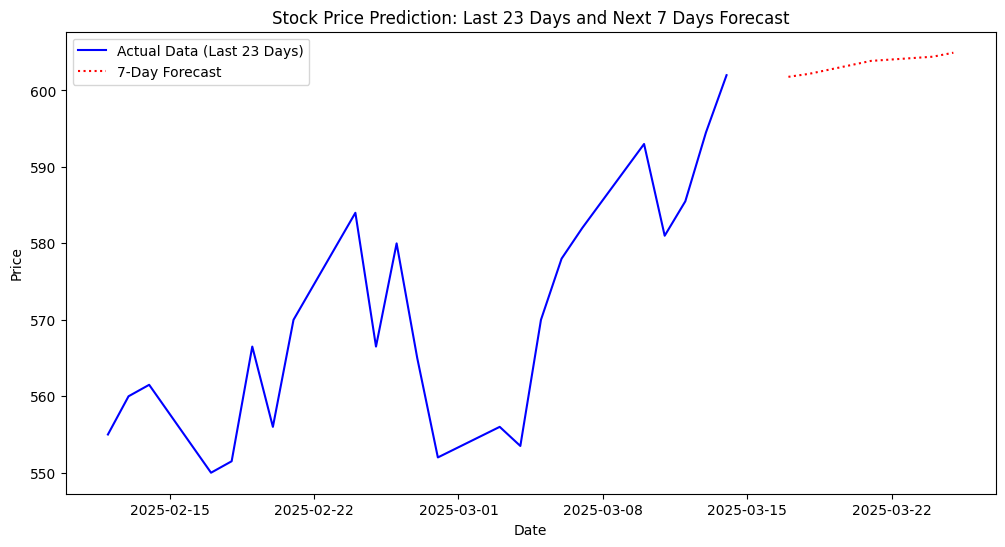

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [29]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [30]:
forecast_df.to_csv('AC_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
